## AnoGAN 개요

대게의 경우 이상 이미지가 정상 이미지보다 매우 적기 때문에, 현실적으로 **정상 이미지만으로 딥러닝을 수행하여 이상 이미지를 검출**해야 하는 알고리즘을 구축해야 함.

AnoGAN은 **생성자 G가 정상 이미지만 생성할 수 있다는 특성을 활용**하여 이상 탐지를 수행

<br/>

1. 일반적인 GAN 모델 학습

2. 테스트할 이미지(생성된 이미지 x, 사전에 정상/비정상 여부는 불분명)와 가장 비슷한 이미지를 생성할 수 있는 noise z를 계산

3. z를 G에 입력하여 이미지를 생성

   - 정상 이미지인 경우 생성된 이미지는 테스트 데이터와 비슷하게 생성됨
   - 이상 이미지인 경우 제대로 생성하지 못함

### Data

In [1]:
! pip install scikit-learn==0.22.1

     |████████████████████████████████| 7.0 MB 3.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.1 which is incompatible.


In [1]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

from sklearn.datasets import fetch_openml

In [3]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [4]:
# 전체 mnist 데이터
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

mnist = fetch_openml('mnist_784', version=1, data_home="./data/")  

X = mnist.data
y = mnist.target

#### GAN 학습용 데이터

정상 이미지만을 대상으로 학습함

In [6]:
# 7, 8에 해당하는 이미지만 저장 (7, 8이 정상 이미지라고 가정)
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [7]:
# 정상 이미지 7, 8
count7 = 0
count8 = 0
max_num = 200  # 7,8에 해당하는 이미지를 200장씩 저장

for i in range(len(X)):
    
    if (y[i] is "7") and (count7 < max_num):
        file_path = "./data/img_78/img_7_" + str(count7) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # PIL
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64
        pil_img_f.save(file_path)  # 저장
        count7 += 1 
    
    if (y[i] is "8") and (count8 < max_num):
        file_path = "./data/img_78/img_8_" + str(count8) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # PIL
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64
        pil_img_f.save(file_path)  # 저장
        count8 += 1
        
    if (count7 >= max_num) and (count8 >= max_num):
        break

#### Test 데이터

학습된 GAN을 바탕으로 이상 탐지 실시

2 : 이상치 

7, 8 : 정상

In [8]:
data_dir_path = "./data/test/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [9]:
i_start = i+1
print(i_start)

2244


In [10]:
# 테스트 데이터 구축
count2 = 0  # 이상치에 해당하는 이미지
count7 = 0
count8 = 0
max_num = 5 

for i in range(i_start, len(X)):  # i_start에서 시작 (train, test 중복 방지)
    
    if (y[i] is "2") and (count2 < max_num):
        file_path = "./data/test/img_2_" + str(count2) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8)) 
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC) 
        pil_img_f.save(file_path)  
        count2 += 1
    
    if (y[i] is "7") and (count7 < max_num):
        file_path = "./data/test/img_7_" + str(count7) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC) 
        pil_img_f.save(file_path)  
        count7 += 1 
    
    if (y[i] is "8") and (count8 < max_num):
        file_path = "./data/test/img_8_" + str(count8) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  
        pil_img_f.save(file_path) 
        count8 += 1 

In [ ]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

### 1. GAN 학습 (DCGAN)

생성자는 동일

판별자 D는 식별 결과(0 : 생성 / 1 : 진짜), 출력 직전의 feature 반환

 - feature는 2단계에서 noise z를 구할 때 사용

#### 1.1 Generator

In [15]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

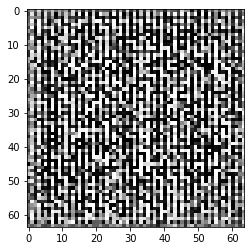

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# random noise
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)  # (1, 20, 1, 1)

# 가짜 이미지 생성
fake_images = G(input_z)

# 시각화
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

#### 1.2 Discriminator

In [17]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 최종 출력 직전 layer의 출력 (1, 512, 4, 4)
        feature = feature.view(feature.size()[0], -1)  # (1, 8192)  

        out = self.last(out)

        return out, feature

In [18]:
D = Discriminator(z_dim=20, image_size=64)

# random 노이즈로 가짜 이미지 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 판별자에 입력으로 제공
d_out = D(fake_images)

# 판별 결과 (초기 상태라 판별 능력 x)
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)

tensor([[[[0.4986]]]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 8192])


### 2. DCGAN 학습

In [19]:
# 학습용 이미지 파일 경로 저장
def make_datapath_list():

    train_img_list = list()  

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

    return train_img_list

# 전처리 class
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),  # Tensor 형식으로
            transforms.Normalize(mean, std)])

    def __call__(self, img):
        return self.data_transform(img)

# GAN 학습용 DataSet
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)
    
    # 전처리한 이미지의 Tensor 형식 데이터 획득
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)  

        img_transformed = self.transform(img)

        return img_transformed

In [23]:
train_img_list = make_datapath_list()

# Dataset 
mean = (0.5, )
std = (0.5, )
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


In [24]:
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        # Conv2d, ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Init
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")

네트워크 초기화 완료


In [25]:
def train_model(G, D, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 손실 함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터
    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)
    
    # Train
    G.train()  
    D.train()  

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0  
        epoch_d_loss = 0.0  

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        for imges in dataloader:  # minibatch
            # --------------------
            # 1. Discriminator 학습
            # --------------------
            if imges.size()[0] == 1:  # minibatch 크기가 1이면 pass
                continue

            imges = imges.to(device)

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            # 진짜 이미지 판정
            d_out_real, _ = D(imges)

            # 가짜 이미지 생성 & 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 손실 계산 (https://github.com/YutaroOgawa/pytorch_advanced/issues/144)
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)

            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 이미지를 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 손실 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    
    print("총 반복 횟수: ", iteration)

    return G, D

In [ ]:
num_epochs = 300  # 300 권장
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

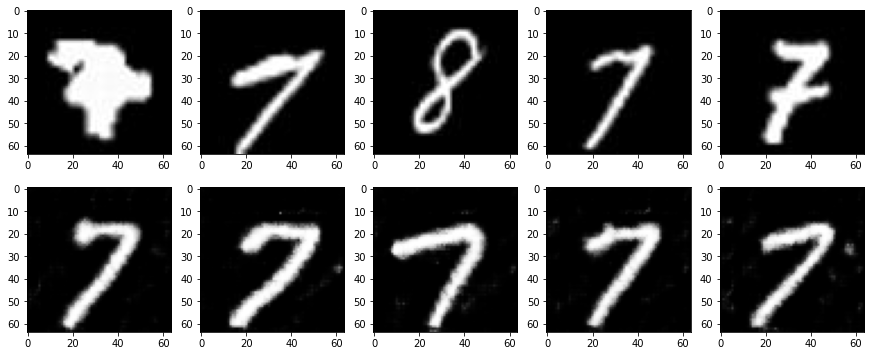

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 학습된 GAN으로 가짜 이미지 생성
fake_images = G_update(fixed_z.to(device))

# 학습 데이터
batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)  

# 시각화 (상단 : 학습용 실제 이미지 / 하단 : 생성된 가짜 이미지)
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

### 3. 생성 noise Z

테스트 이미지와 가장 비슷한 가짜 이미지를 생성하는 노이즈

1. z로 이미지 생성 (처음에는 난수로)

2. 생성된 이미지와 테스트 이미지의 채널 별 픽셀 차이의 절댓값 합을 손실로 계산

   - 판별자 D에서 테스트 이미지, 생성된 이미지의 feature간 픽셀 차이를 계산하여 합산

3. 2의 손실 값에 대한 z의 미분 계산 & 갱신

4. 1~3 반복

In [32]:
# 초기 random noise
z = torch.randn(5, 20)
# z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 손실에 대한 미분이 가능하도록 설정
z.requires_grad = True

# 그래디언트에 따라 갱신이 가능하도록 최적화 함수 설정
z_optimizer = torch.optim.Adam([z], lr=1e-3)

#### AnoGAN 핵심

In [38]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):
    
    # 테스트 이미지 x, 생성된 이미지 간의 픽셀 별 차이의 절댓값 계산 & minibatch마다 합 계산
    residual_loss = torch.abs(x - fake_img)  # (N, 1, 64, 64)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)  # (N, 4096)
    residual_loss = torch.sum(residual_loss, dim=1)  # (N, )

    # 테스트 이미지, 생성된 이미지를 D에 입력하여 feature 출력
    _, x_feature = D(x)
    _, G_feature = D(fake_img)

    # 테스트 이미지의 feature, 생성된 이미지의 feature 간의 픽셀 별 차이의 절댓값 계산 & minibatch마다 합 계산
    discrimination_loss = torch.abs(x_feature - G_feature)  # (5, 8192)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)  # (5, 8192)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)  # (5, )

    # Total loss
    loss_each = (1 - Lambda) * residual_loss + Lambda * discrimination_loss  # minibatch마다 위의 2 종류의 손실을 더함
    total_loss = torch.sum(loss_each)  # 모든 minibatch의 손실 계산

    return total_loss, loss_each, residual_loss

In [39]:
def make_test_datapath_list():

    train_img_list = list()  

    for img_idx in range(5):
        img_path = "./data/test/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

test_img_list = make_test_datapath_list()

# Dataset
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

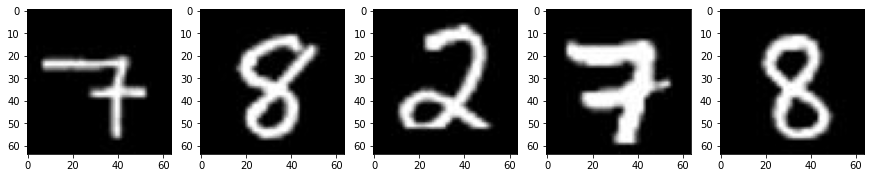

In [40]:
# 이상 탐지용 테스트 이미지 (7, 8 : 정상 / 2 : 이상치)
batch_iterator = iter(test_dataloader)  
imges = next(batch_iterator)  

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

In [41]:
# 이상 탐지용 이미지
x = imges[0:5]
x = x.to(device)

# 이상 탐지할 화상을 생성하기 위한 초기 noise
z = torch.randn(5, 20)
z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# z를 손실에 대해 미분 가능하도록 설정 & 그래디언트를 기반으로 갱신되도록 최적화 함수 설정
z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)

# 생성 noise 구하기 (학습된 GAN을 이용하여 테스트 이미지와 가장 비슷한 이미지를 생성)
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()  # 역전파
    z_optimizer.step()  # 그래디언트를 구한 후 loss를 낮추는 방향으로 z를 갱신

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))

epoch 0 || loss_total:6835 
epoch 1000 || loss_total:4428 
epoch 2000 || loss_total:3702 
epoch 3000 || loss_total:2912 
epoch 4000 || loss_total:2745 
epoch 5000 || loss_total:2586 


### 4. 이상 탐지

total loss:  [548. 321. 823. 563. 328.]


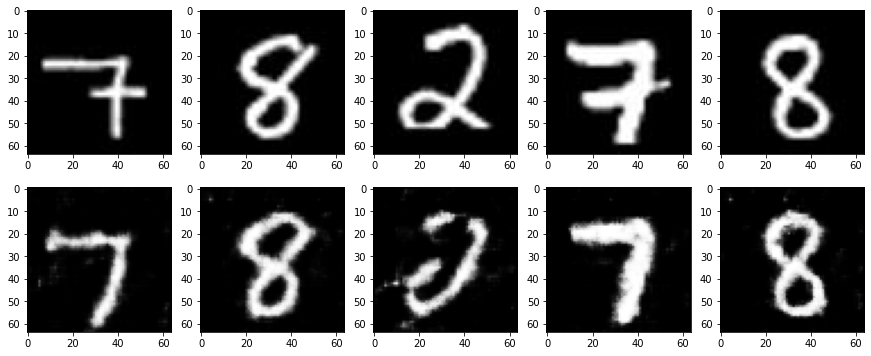

In [42]:
G_update.eval()
fake_img = G_update(z)  # 학습된 생성 noise z를 생성자에 입력하여 가짜 이미지 생성

loss, loss_each, residual_loss_each = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

loss_each = loss_each.cpu().detach().numpy()
print("total loss: ", np.round(loss_each, 0))

# 상단 : 이상 탐지용 실제 이미지 / 하단 : 생성된 가짜 이미지
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')

이상 탐지용 테스트 이미지와 비슷한 이미지를 생성할 수 있도록 noise z를 학습시켰지만, 이상치에 해당하는 숫자 2는 제대로 생성되지 못하는 것을 확인
(실제로 total loss가 가장 큼)


생성 노이즈 z를 계산하는데 있어 오랜 시간이 걸림 (epcoh 많이 필요)

**생성 노이즈를 테스트 이미지로 구하는 별도의 딥러닝 모델 구축의 필요성 (Efficient GAN)**